In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
from copy import deepcopy as copy

IMG_PATH = "_img"
CACHE_PATH = "../fitting/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

from itertools import combinations
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries
from MaStarChecks.preprocessing import build_train_test
from MaStarChecks.plotting.analysis import build_comparison_table, consistency_plot, delta_plot, delta_inset_plot
from MaStarChecks.plotting.styles import GSL_COLOR, Y19_COLOR, MASTAR_CMAP, MASTAR_COLOR, LIGHT_COLOR, MED_COLOR


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.2")

LABELS = ("GSL", "MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r""]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"], units.values())}

In [2]:
# TODO: use the spectral energy distributions in physical units to improve the logg estimation

spectra, catalogues = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, use_cache=False, cache_path=CACHE_PATH)

catalogue = pd.DataFrame()
for label, c in catalogues.items():
    c["LIBRARY"] = label
    catalogue = catalogue.append(c, ignore_index=True)

catalogue.rename(columns=cols, inplace=True)
spectra = pd.concat([s["FLUX"] for label, s in spectra.items()], axis="index", ignore_index=True)

catalogue[cols.get("TEFF")] = np.log10(catalogue[cols.get("TEFF")])

y = catalogue.filter(items=list(cols.values()))
# masking stars with weird alpha abundances
y = y.mask((catalogue.LIBRARY=="MaStar")&(y[cols.get("ALPHAM")]<=-0.1))

training_set, testing_set, labelled_set = build_train_test(labels=y, test_ratio=0.10, random_state=123, verbose=True)

X_train = spectra.loc[training_set]
y_train = y.loc[training_set]

X_test = spectra.loc[testing_set]
y_test = y.loc[testing_set]

X_labelled = spectra.loc[labelled_set]
y_labelled = y.loc[labelled_set]
y_labelled[cols.get("TEFF")] = 10**y_labelled[cols.get("TEFF")]

training_set_gsl = training_set[catalogue.loc[training_set].LIBRARY=="GSL"]
training_set_y19 = training_set[catalogue.loc[training_set].LIBRARY=="MaStar"]
testing_set_gsl = testing_set[catalogue.loc[testing_set].LIBRARY=="GSL"]
testing_set_y19 = testing_set[catalogue.loc[testing_set].LIBRARY=="MaStar"]

100%|##################################################| reading FITS for GSL: 30256/30256 [04:36<00:00, 109.45FITS/s]
100%|##################################################| extracting GSL catalogue: 30256/30256 [00:42<00:00, 710.42record/s]
100%|##################################################| extracting FLUX from GSL: 30256/30256 [00:12<00:00, 2350.76SED/s]
100%|##################################################| reading FITS for MaStar: 20332/20332 [04:09<00:00, 81.63FITS/s]
100%|##################################################| extracting MaStar catalogue: 20332/20332 [00:27<00:00, 727.27record/s]
100%|##################################################| extracting FLUX from MaStar: 20332/20332 [00:06<00:00, 2995.90SED/s]


labelled set : 32796
training set : 29516
testing set  : 3280


In [3]:
# xxx = y_train.copy()
# xxx[cols.get("TEFF")] = 10**xxx[cols.get("TEFF")]
# print(xxx.agg(["min","max"]).T.to_html())

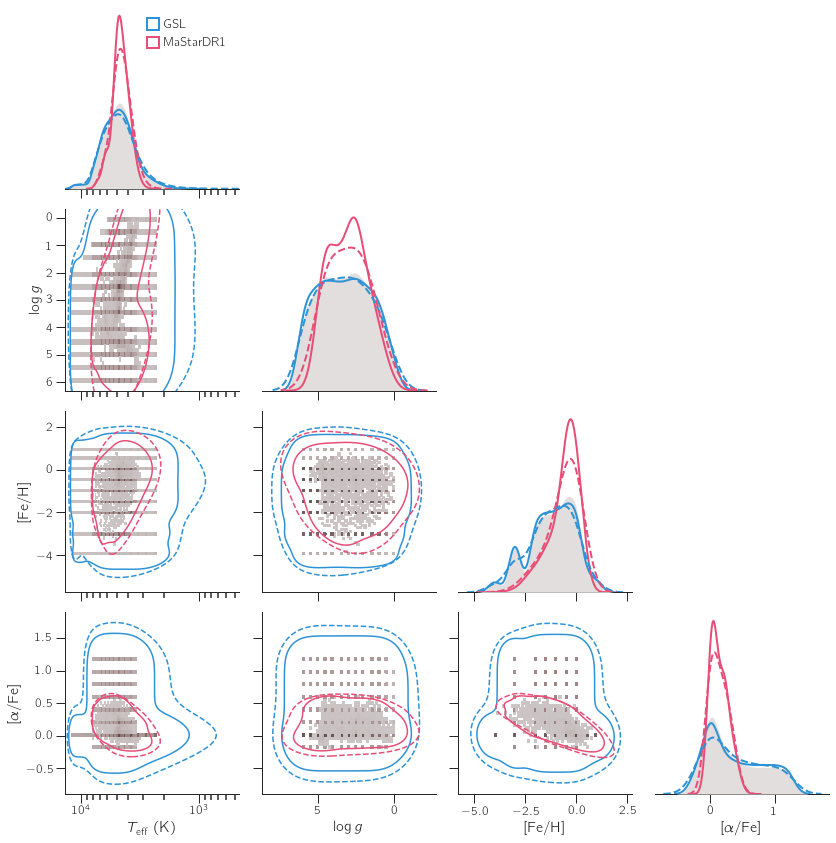

In [4]:
g = sns.pairplot(y_labelled, kind="hist", diag_kind="kde", corner=True, height=3,
                 plot_kws={"stat":"density", "color":LIGHT_COLOR, "alpha":1.0, "linewidth":0},
                 diag_kws={"shade":True, "bw_adjust":2, "lw":0, "color":LIGHT_COLOR, "alpha":1.0},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
for (i, column), ax in zip(enumerate(y.columns), g.diag_axes):
    
    sns.kdeplot(x=y_labelled.loc[training_set_gsl,column], bw_adjust=2, color=GSL_COLOR, lw=2, ax=ax)
    sns.kdeplot(x=y_labelled.loc[training_set_y19,column], bw_adjust=2, color=Y19_COLOR, lw=2, ax=ax)
    
    sns.kdeplot(x=y_labelled.loc[testing_set_gsl,column], bw_adjust=2, color=GSL_COLOR, lw=2, ls="--", ax=ax)
    sns.kdeplot(x=y_labelled.loc[testing_set_y19,column], bw_adjust=2, color=Y19_COLOR, lw=2, ls="--", ax=ax)
    
for (column_x,column_y), (j,i) in zip(combinations(y.columns, 2), (combinations([0,1,2,3], 2))):
    sns.kdeplot(x=y_labelled.loc[training_set_gsl,column_x],
                y=y_labelled.loc[training_set_gsl,column_y],
                bw_adjust=2, levels=(0.01,), color=GSL_COLOR, linewidths=1.5, ax=g.axes[i,j])
    sns.kdeplot(x=y_labelled.loc[training_set_y19,column_x],
                y=y_labelled.loc[training_set_y19,column_y],
                bw_adjust=2, levels=(0.01,), color=Y19_COLOR, linewidths=1.5, ax=g.axes[i,j])
    
    sns.kdeplot(x=y_labelled.loc[testing_set_gsl,column_x],
                y=y_labelled.loc[testing_set_gsl,column_y],
                bw_adjust=2, levels=(0.01,), color=GSL_COLOR, linewidths=1.5, linestyles="--", ax=g.axes[i,j])
    sns.kdeplot(x=y_labelled.loc[testing_set_y19,column_x],
                y=y_labelled.loc[testing_set_y19,column_y],
                bw_adjust=2, levels=(0.01,), color=Y19_COLOR, linewidths=1.5, linestyles="--", ax=g.axes[i,j])

handles = [mpatches.Patch(edgecolor=GSL_COLOR, facecolor="none", lw=2, label="GSL"),
           mpatches.Patch(edgecolor=Y19_COLOR, facecolor="none", lw=2, label="MaStarDR1")]
legend = g.axes[0,0].legend(handles=handles, loc=1)

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
# g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(3))
# g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(2))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])

g.fig.savefig("../analysis/_img/training-testing-sets.png", bbox_inches="tight")

In [5]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pickle


pickle_filename = "_cache/estimator-mor-v3.1.2-cleaned-v2-gsl.pk"

if not os.path.isfile(pickle_filename):
    mor = {}
    mor["mode"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="ls",
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)
    
    mor["P16"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="quantile",
        alpha=0.16,
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)
    
    mor["P50"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="quantile",
        alpha=0.50,
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)
    
    mor["P84"] = MultiOutputRegressor(GradientBoostingRegressor(
        verbose=1,
        random_state=0,
        learning_rate=0.1,
        loss="quantile",
        alpha=0.84,
        max_depth=4,
        min_samples_split=5,
        n_estimators=100
    ), n_jobs=-1).fit(X_train, y_train)

    pickle.dump(mor, open(pickle_filename, "wb"))
else:
    mor = pickle.load(open(pickle_filename, "rb"))

In [6]:
y_model = pd.DataFrame(index=y.index, columns=y.columns, data=mor["mode"].predict(spectra))
y[cols.get("TEFF")] = 10**y[cols.get("TEFF")]
y_model[cols.get("TEFF")] = 10**y_model[cols.get("TEFF")]
y_model

$T_\mathrm{eff}$~(K)  $\log{g}$  $[\mathrm{Fe}/\mathrm{H}]$  \
0               2341.964722   0.198696                    0.481681   
1               2311.342898   0.554475                    0.861983   
2               2302.335043   0.295230                    0.019211   
3               2358.893831   0.357427                   -0.333759   
4               2361.686279   0.189977                   -0.861041   
...                     ...        ...                         ...   
50583           4967.932947   4.501228                   -0.010660   
50584           4750.940594   1.930024                   -1.318554   
50585          11024.435221   4.363712                   -0.580535   
50586           4543.331993   2.745404                    0.150711   
50587           6507.669449   4.064512                   -0.363913   

       $[\alpha/\mathrm{Fe}]$  
0                   -0.008866  
1                   -0.034736  
2                   -0.008739  
3                    0.015257  
4                    0.019549  
...                       ...  
50583                0.054728  
50584                0.219840  
50585               -0.008217  
50586                0.099890  
50587                0.108891  

[50588 rows x 4 columns]

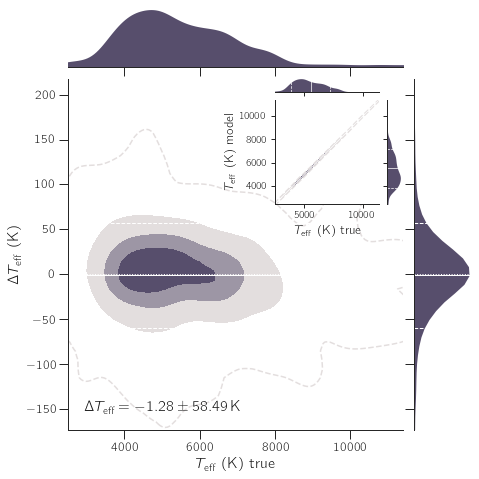

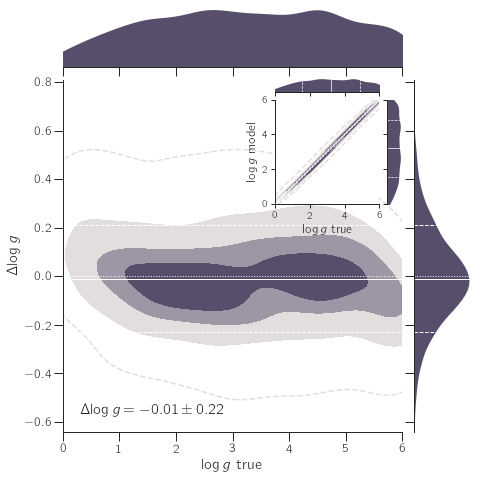

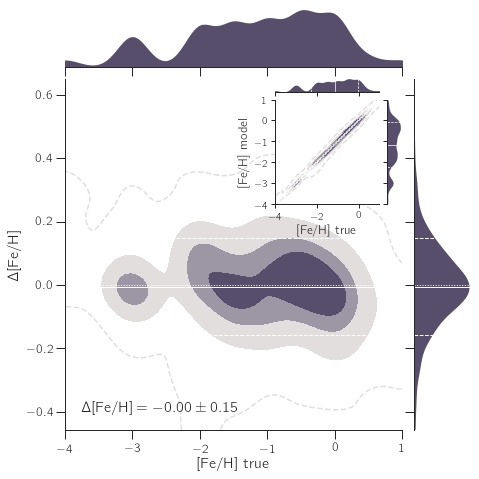

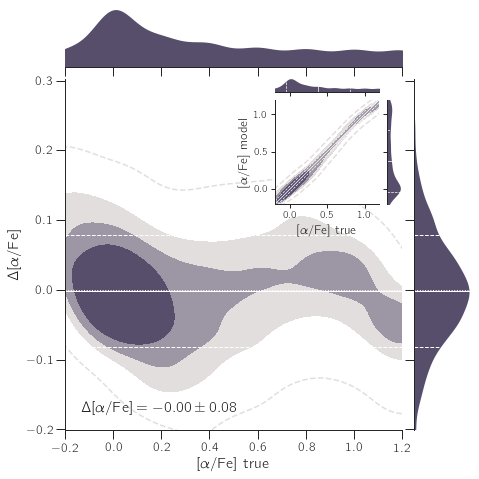

In [7]:
compare_with = "true"
comparison = build_comparison_table(y_model.loc[testing_set], y.loc[testing_set], labela="model", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\Delta$")

for label, column in cols.items():
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="model", delta_prefix=r"$\Delta$"
        )
#     d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")

(6.905778084369829, -0.9304107152395754)

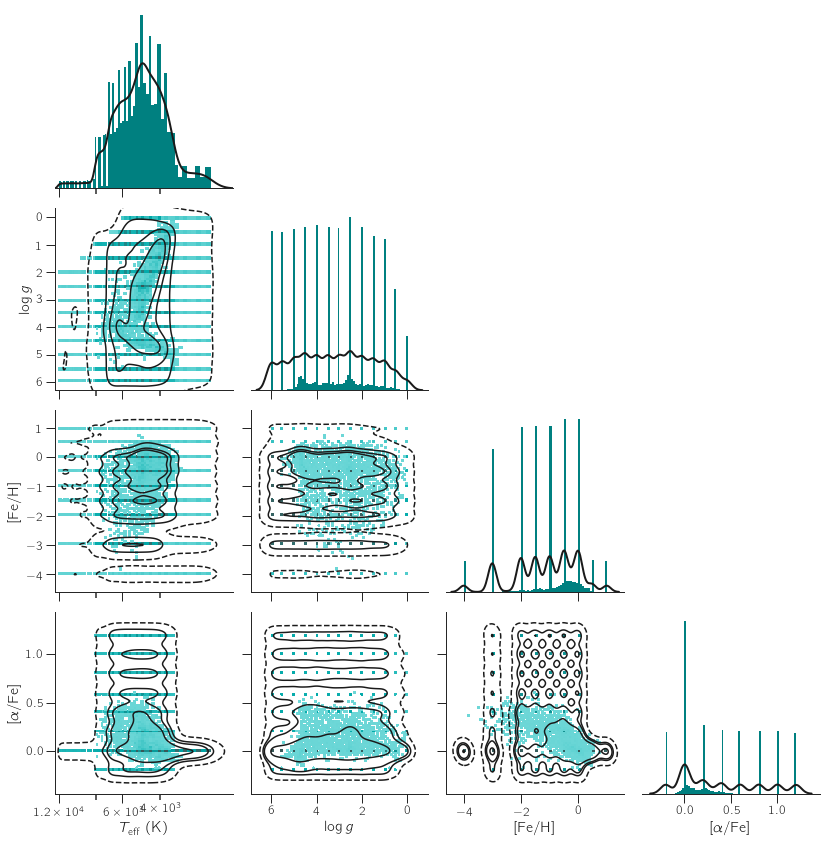

In [8]:
g = sns.pairplot(y.loc[training_set], kind="hist", corner=True, height=3,
                 plot_kws={"color":"teal", "bins":70, "stat":"density"},
                 diag_kws={"lw":0, "fc":"teal", "bins":70, "stat":"density"},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.map_diag(sns.kdeplot, lw=2, color="k")
g.map_lower(sns.kdeplot,
            levels=(0.05,0.25,0.50,0.75,1.00), color="k", linewidths=1.5, linestyles=("--","-","-","-","-"))

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(1))
g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])

(7.301785278510186, -1.3017852785101862)

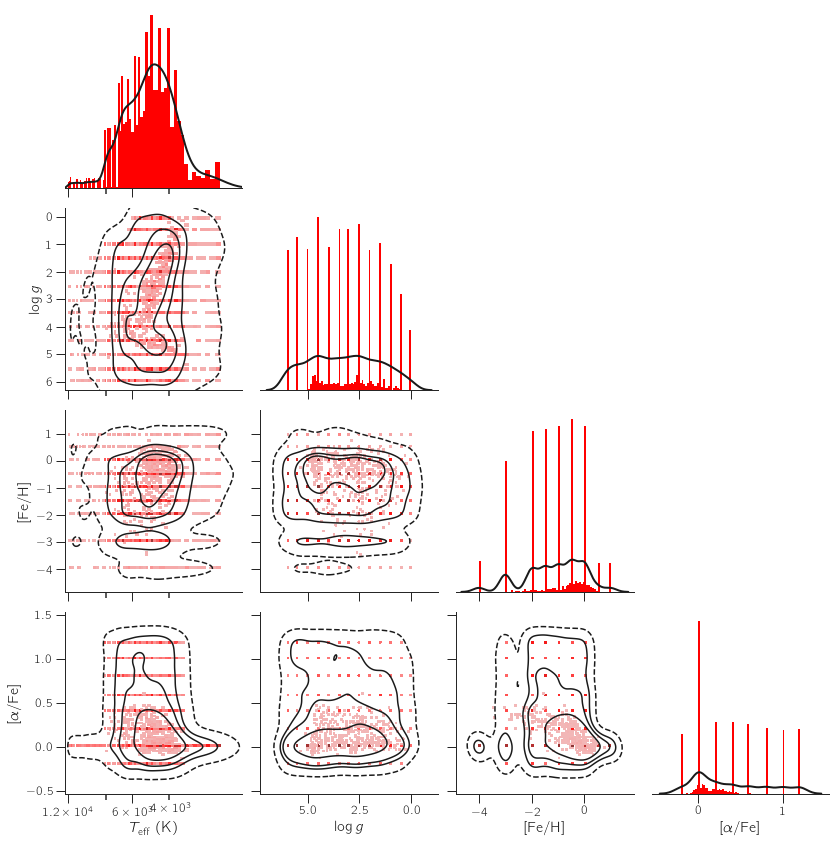

In [9]:
g = sns.pairplot(y.loc[testing_set], kind="hist", corner=True, height=3,
                 plot_kws={"color":"red", "bins":70, "stat":"density"},
                 diag_kws={"lw":0, "fc":"red", "bins":70, "stat":"density"},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.map_diag(sns.kdeplot, lw=2, color="k")
g.map_lower(sns.kdeplot,
            levels=(0.05,0.25,0.50,0.75,1.00), color="k", linewidths=1.5, linestyles=("--","-","-","-","-"))

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(1))
g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])

(6.288457684923208, -1.299033873134384)

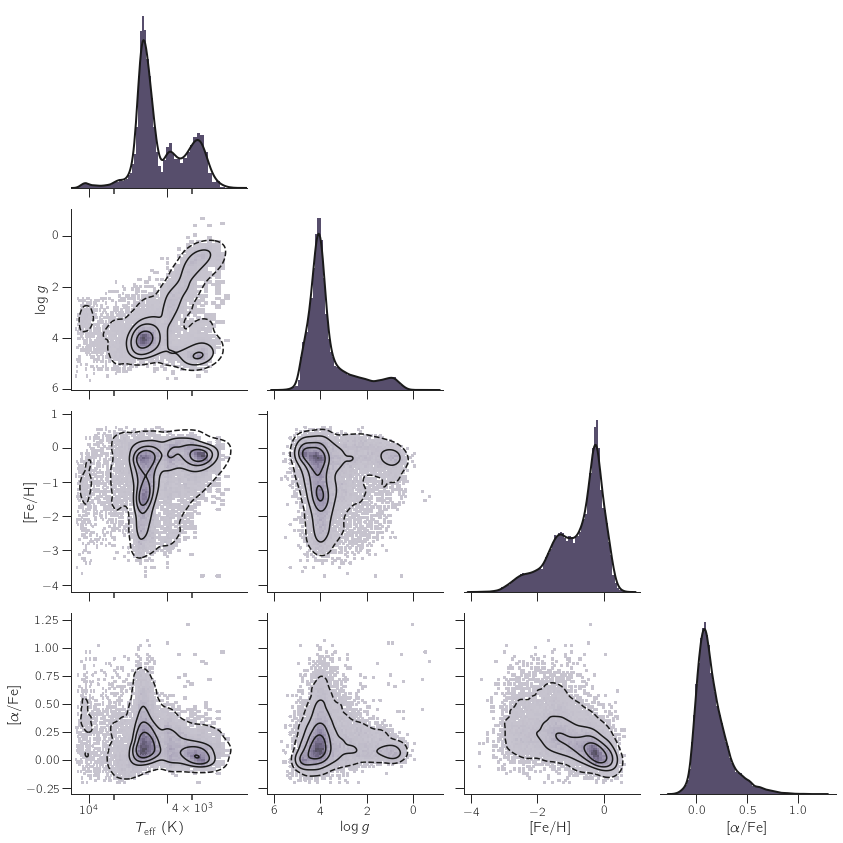

In [10]:
g = sns.pairplot(y_model.loc[catalogue.LIBRARY=="MaStar"], kind="hist", corner=True, height=3,
                 plot_kws={"color":MASTAR_COLOR, "bins":70, "stat":"density"},
                 diag_kws={"lw":0, "fc":MASTAR_COLOR, "bins":70, "stat":"density"},
                 grid_kws={"diag_sharey":False}
)
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.map_diag(sns.kdeplot, lw=2, color="k")
g.map_lower(sns.kdeplot,
            levels=(0.05,0.25,0.50,0.75,1.00), color="k", linewidths=1.5, linestyles=("--","-","-","-","-"))

g.axes[1,0].set_xscale("log")
g.axes[1,0].set_xlim(xlim[::-1])
g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(1))
g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])

In [11]:
import shutil
from astropy.io import fits
from MaStarChecks.constants import BAR_FORMAT


mastar_idx = catalogue.index[catalogue.LIBRARY=="MaStar"]
X_mastar = spectra.loc[mastar_idx]
y_mastar = pd.DataFrame(index=catalogue.loc[mastar_idx, "ID"], columns=Y_COLUMNS, data=mor["mode"].predict(X_mastar))
y_mastar.TEFF = 10**y_mastar.TEFF

sed_list = sorted([f"processed-mastar-{ID}-{rec}.fits.gz" for ID, rec in zip(catalogue.ID.loc[X_mastar.index],catalogue.RECORD.loc[X_mastar.index].astype(int))])

CLASSIFIED_PATH = "../fitting/_data/classified-mastar-v3.1.2-cleaned-v2-gsl"
if not os.path.isdir(CLASSIFIED_PATH):
    os.mkdir(CLASSIFIED_PATH)

    for filename in tqdm(sed_list, desc="updating parameters", unit="star", ascii=True, bar_format=BAR_FORMAT):
        filename_src = os.path.join(PROCESSED_PATH, filename)
        filename_dst = os.path.join(CLASSIFIED_PATH, filename.replace("processed","classified-gsl"))
        if not os.path.isfile(filename_dst): shutil.copyfile(filename_src, filename_dst)

        with fits.open(filename_dst, "update") as sed_fits:
            for column in Y_COLUMNS:
                sed_fits[0].header[column] = y_mastar.loc[sed_fits[0].header["ID"], column]

In [12]:
import tarfile


def chunks(l, n):
    """Taken from https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks"""
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

COMPRESSED_PATH = "../_data/mastar-v3.1.2-classified-cleaned-v2-gsl"
if not os.path.isdir(COMPRESSED_PATH):
    os.mkdir(COMPRESSED_PATH)

    sed_list = sorted([os.path.join(CLASSIFIED_PATH, filename) for filename in os.listdir(CLASSIFIED_PATH) if filename.startswith("classified-gsl") and filename.endswith(".fits.gz") and "mastar" in filename])
    sed_chunks = list(enumerate(chunks(sed_list, 1000)))
    for i, chunk in tqdm(sed_chunks, desc="compressing chunks", unit="chunk", ascii=True, bar_format=BAR_FORMAT):
        compressed_filename = os.path.join(COMPRESSED_PATH, "mastar-seds-chunk-{:03d}.tar.bz2".format(i))
        if os.path.isfile(compressed_filename): continue
        with tarfile.open(compressed_filename, "w:bz2") as tar:
            for file in chunk:
                tar.add(file)